# Generate Human Faces using GAN

### How does GANs work?

**GANs** learn a probability distribution of a dataset by pitting two neural networks against each other.


One neural network, called the **Generator**, generates new data instances, while the other, the **Discriminator**, evaluates them for authenticity; i.e. the discriminator decides whether each instance of data that it reviews belongs to the actual training dataset or not.

The goal of the generator is to generate passable images: to lie without being caught. The goal of the discriminator is to identify images coming from the generator as fake.


Here are the steps a GAN takes:

1. The generator takes in random numbers and returns an image.

2. This generated image is fed to the discriminator alongside a stream of actual ground truth images.

3. The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

So you have a double feedback loop:

1. The discriminator is in a feedback loop with the ground truth of the images, which we know.

2. The generator is in a feedback loop with the discriminator.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

### Load the data and resize the iamges

In [2]:
from PIL import Image
pic_dir = f'../input/celeba-dataset/img_align_celeba/img_align_celeba/'

image_count = 5000

orig_width = 178
orig_height = 208
diff = (orig_height - orig_width) // 2

width = 128
height = 128

crop_rect = (0, diff, orig_width, orig_height - diff)

images = []
for pic_file in tqdm(os.listdir(pic_dir)[:image_count]):
    pic = Image.open(pic_dir + pic_file).crop(crop_rect)
    pic.thumbnail((width, height), Image.ANTIALIAS)
    images.append(np.uint8(pic))

100%|██████████| 5000/5000 [00:42<00:00, 118.25it/s]


### Display first 10 images

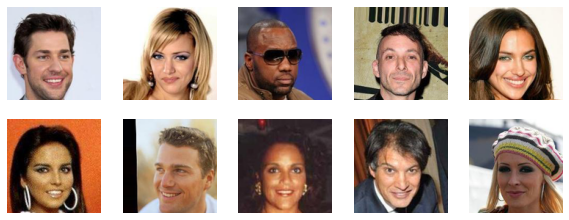

In [3]:
# Display first 10 images
plt.figure(1, figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

Scale images 

In [4]:
# Image shape
images = np.array(images) / 255
print(f'Total Images - {images.shape[0]}  Image Size - {images.shape[1]} x {images.shape[2]}')

Total Images - 5000  Image Size - 128 x 128


### The next step is to create a Generator

In [5]:
latent_dim = 32
channels = 3

def create_generator():
    gen_input = Input(shape=(latent_dim, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(channels, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

### Create a Discriminator


In [6]:
import tensorflow
def create_discriminator():
    disc_input = Input(shape=(height, width, channels))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = tensorflow.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator

### Define a GAN Model

Next, a GAN model can be defined that combines both the generator model and the discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only affects when training the combined GAN model, not when training the discriminator standalone.

This larger GAN model takes as input a point in the latent space, uses the generator model to generate an image, which is fed as input to the discriminator model, then output or classified as real or fake.

Since the output of the Discriminator is sigmoid, we use binary cross-entropy for the loss. RMSProp as an optimizer generates more realistic fake images compared to Adam for this case. The learning rate is 0.0001. Weight decay and clip value stabilize learning during the latter part of the training. You have to adjust the decay if you want to adjust the learning rate.

GANs try to replicate a probability distribution. Therefore, we should use loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data.

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)      

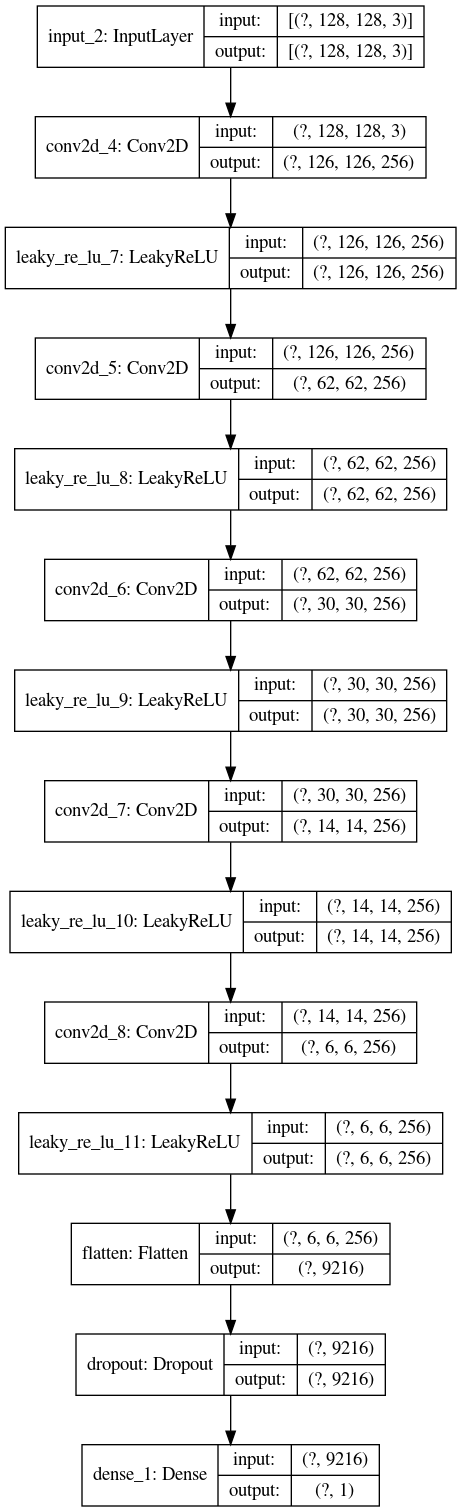

In [7]:
from IPython.display import Image
from tensorflow.keras.utils import model_to_dot

generator = create_generator()
generator.summary()
Image(model_to_dot(generator, show_shapes=True).create_png())

discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Image(model_to_dot(discriminator, show_shapes=True).create_png())

In [8]:
gan_input = Input(shape=(latent_dim, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [9]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [10]:
gan.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
functional_1 (Functional)    (None, 128, 128, 3)       14953987  
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 4211713   
Total params: 19,165,700
Trainable params: 14,953,987
Non-trainable params: 4,211,713
_________________________________________________________________


### Training the GAN model:


Training is the hardest part and since a GAN contains two separately trained networks, its training algorithm must address two complications:

GANs must juggle two different kinds of training (generator and discriminator).

GAN convergence is hard to identify.

In [11]:
import time
iters = 10000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, latent_dim)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((width * CONTROL_SIZE_SQRT, height * CONTROL_SIZE_SQRT, channels))
        control_generated = generator.predict(control_vectors)
        
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * width:(x_off + 1) * width, y_off * height:(y_off + 1) * height, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


50/10000: d_loss: 0.6045,  a_loss: 0.9299.  (1.1 sec)
100/10000: d_loss: 0.6331,  a_loss: 0.6616.  (1.2 sec)
150/10000: d_loss: 0.6366,  a_loss: 0.8255.  (1.2 sec)
200/10000: d_loss: 0.6884,  a_loss: 0.8029.  (1.3 sec)
250/10000: d_loss: 0.5872,  a_loss: 0.8458.  (1.2 sec)
300/10000: d_loss: 0.6556,  a_loss: 1.0029.  (1.2 sec)
350/10000: d_loss: 0.6341,  a_loss: 0.7727.  (1.2 sec)
400/10000: d_loss: 0.6698,  a_loss: 0.7822.  (1.2 sec)
450/10000: d_loss: 0.6822,  a_loss: 0.8635.  (1.2 sec)
500/10000: d_loss: 0.6046,  a_loss: 0.8122.  (1.2 sec)
550/10000: d_loss: 0.6712,  a_loss: 0.8817.  (1.2 sec)
600/10000: d_loss: 0.6478,  a_loss: 1.2436.  (1.2 sec)
650/10000: d_loss: 0.6704,  a_loss: 0.8870.  (1.2 sec)
700/10000: d_loss: 0.6181,  a_loss: 0.9918.  (1.2 sec)
750/10000: d_loss: 0.7236,  a_loss: 1.3237.  (1.2 sec)
800/10000: d_loss: 0.6689,  a_loss: 0.8935.  (1.2 sec)
850/10000: d_loss: 0.6302,  a_loss: 1.3114.  (1.2 sec)
900/10000: d_loss: 0.6832,  a_loss: 1.1769.  (1.2 sec)
950/10000: 

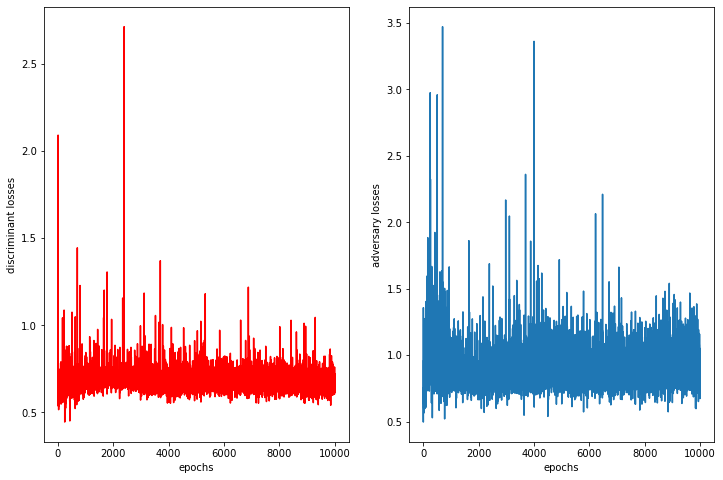

In [15]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

### Display 20 output images that have been generated.

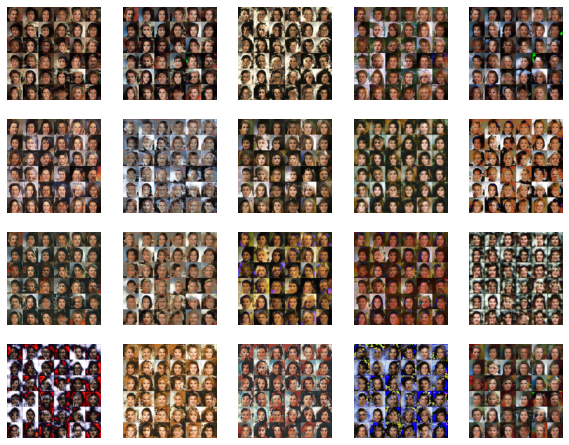

In [16]:
import imageio
from IPython.display import display, Image
import os

RES_DIR = 'res2'

images = list()

for filename in os.listdir(RES_DIR):
    images.append(imageio.imread(RES_DIR + '/' + filename))

# Display first 20 images
plt.figure(1, figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

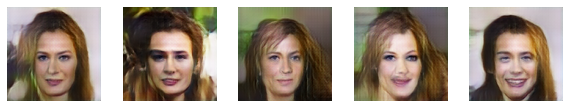

In [30]:
# Display first 20 images
plt.figure(1, figsize=(10, 10))
for i in range(5):
    plt.subplot(5, 5, i+1)
    
    control_size_sqrt = 3
    control_vectors = np.random.normal(size=(control_size_sqrt**2, latent_dim)) / 2

    control_image = np.zeros((width, height, channels))
    control_generated = generator.predict(control_vectors)
    plt.imshow(control_generated[0, :, :])
    plt.axis('off')

In [ ]:
import imageio
from IPython.display import display, Image
import shutilimages_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
    
imageio.mimsave('trainnig_visual.gif', images_to_gif)
#shutil.rmtree(RES_DIR)


display(Image(filename="trainnig_visual.gif"))

Check the output here.

https://giphy.com/gifs/QuDO8a4UBfyZrLP331?utm_source=iframe&utm_medium=embed&utm_campaign=Embeds&utm_term=https%3A%2F%2Fwww.kdnuggets.com%2F

In [3]:
import os
print(os.listdir(os.getcwd()))

[]
